In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia

from astropy.coordinates import SkyCoord, Galactic
import astropy.units as u

# Pulling the Unresolved Binaries from O'Brien (Table A4)

In [3]:
query = """
SELECT
    gs.source_id,                
    gs.ra,                      
    gs.dec,                     
    gs.parallax,               
    gs.phot_g_mean_mag,  -- absolute
    gs.phot_g_mean_flux, -- apparent   
    gs.phot_bp_mean_mag,  -- absolute
    gs.phot_bp_mean_flux, -- apparent   
    gs.phot_rp_mean_mag,  -- absolute
    gs.phot_rp_mean_flux, -- apparent     
    ap.classprob_dsc_combmod_whitedwarf, 
    ap.classprob_dsc_combmod_binarystar,
    ap.teff_gspphot,
    ap.lum_flame,
    ap.radius_flame,
    ap.mass_flame
FROM
    gaiadr3.gaia_source AS gs   
LEFT JOIN
    gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE
    gs.source_id IN (
        1355264565043431040, 
        3223516063958808064,
        1005873614080407296,
        2185710338703934976,
        4788741548375134336,
        6431977687725247104,
        3729017810434416128,
        1548104507825815296,
        1550299304833675392,
        4478524169500496000,
        2643862402903084544,
        3845263368043086080,
        759601941671398272,
        3000597125173673088
    )
"""


In [4]:
job = Gaia.launch_job(query)
results = job.get_results()

# Galactocentric coordinates

In [5]:
# Turning the string into integers
parallax = results['parallax']
parallax = np.array(parallax)

ra = results['ra']
ra = np.array(ra)

dec = results['dec']
dec = np.array(dec)

#using parallax for postion 
arcsecond = parallax/1000
distance = abs(1/arcsecond)
coords = SkyCoord(ra*u.deg, dec*u.deg, distance*u.pc , frame='icrs')
galactic = coords.transform_to(Galactic)

#gives postions 
X = (galactic.cartesian.x)/u.pc
Y = (galactic.cartesian.y)/u.pc
Z = (galactic.cartesian.z)/u.pc

In [6]:
# Create a dictionary with the results and the boundary parameters
data = {
    'source_id' : results['SOURCE_ID'],
    'ra' : results['ra'],
    'dec' : results['dec'],
    'parallax' : results['parallax'],
    'G_mag' : results['phot_g_mean_mag'],
    'g_flux' : results['phot_g_mean_flux'],         # [e/s]
    'BP_mag' : results['phot_bp_mean_mag'],
    'bp_flux' : results['phot_bp_mean_flux'],       # [e/s]
    'RP_mag' : results['phot_rp_mean_mag'],
    'rp_flux' : results['phot_rp_mean_flux'],       # [e/s]
    'WD_prob' : results['classprob_dsc_combmod_whitedwarf'],
    'Binary_prob' : results['classprob_dsc_combmod_binarystar'],
    'T_eff' : results['teff_gspphot'],
    'lum_flame' : results['lum_flame'],
    'radius_flame' : results['radius_flame'],
    'mass_flame' : results['mass_flame'],
    'X' : X,
    'Y' : Y,
    'Z' : Z 
}
#df = pd.DataFrame(data)

In [7]:
# plt.scatter(df['X'], df['Y'], c='k', s=5)
# plt.xlabel('X axis (pc)')
# plt.ylabel('Y axis (pc)')

# Exposure Times

In [8]:
# when the bands get saturated 
Sat_lim_UVB = 41300     #e
Sat_lim_VIS = 41900     #e
Sat_lim_NIR = 103000    #e
# We decided to go with a SNR of 500 
SNR = 500

In [9]:
# # Testing the math
# e_count = SNR**2

# bp = df['bp_flux'][10] 
# g = df['g_flux'][10]
# rp = df['rp_flux'][10]

# # min exposure time per band 
# min_time_uvb = e_count / bp     #[sec]
# print(min_time_uvb)
# min_time_vis = e_count / g      #[sec]
# min_time_nir = e_count / rp     #[sec]

# # Time it takes for the filter to become saturated
# S_time_uvb = Sat_lim_UVB / bp          #[sec]
# print(S_time_uvb)
# S_time_vis = Sat_lim_VIS / g           #[sec]
# S_time_nir = Sat_lim_NIR / rp          #[sec]
    
# # Get the whole number of exposures to prevent saturation, then add 1
# Num_exp_uvb = int(min_time_uvb // S_time_uvb ) + 1
# print(Num_exp_uvb)
# Num_exp_vis = int(min_time_vis // S_time_vis ) + 1
# Num_exp_nir = int(min_time_nir // S_time_nir ) + 1

# # Time for each exposure, based on what is smaller, saturation time or the min time 
# Time_per_uvb = min_time_uvb / Num_exp_uvb
# print(Time_per_uvb)
# Time_per_vis = min_time_vis / Num_exp_vis
# Time_per_nir = min_time_nir / Num_exp_nir

# print('UVB:', Num_exp_uvb, Time_per_uvb, (Num_exp_uvb * Time_per_uvb))
# print('VIS:', Num_exp_vis, Time_per_vis, (Num_exp_vis * Time_per_vis))
# print('NIR:', Num_exp_nir, Time_per_nir, (Num_exp_nir * Time_per_nir))

# ### Cool it works lets make it a function to automate over all the candidates & append the values 

In [10]:
# SNR, next 3 are the flux for each source, next 3 are the saturation constants
def min_exp(SNR, bp, g, rp, S_bp, S_g, S_rp):
    # SNR = N**(1/2), therefore we need an electron count of 
    e_count = SNR**2

    # min exposure time per band 
    min_time_uvb = e_count / bp     #[sec]
    min_time_vis = e_count / g      #[sec]
    min_time_nir = e_count / rp     #[sec]

    # Time it takes for the filter to become saturated
    S_time_uvb = S_bp / bp          #[sec]
    S_time_vis = S_g / g            #[sec]
    S_time_nir = S_rp / rp          #[sec]
    
    # Get the whole number of exposures to prevent saturation, then add 1
    Num_exp_uvb = int(min_time_uvb // S_time_uvb ) + 1
    Num_exp_vis = int(min_time_vis // S_time_vis ) + 1
    Num_exp_nir = int(min_time_nir // S_time_nir ) + 1

    # Time for each exposure 
    Time_per_uvb = min_time_uvb / Num_exp_uvb
    Time_per_vis = min_time_vis / Num_exp_vis
    Time_per_nir = min_time_nir / Num_exp_nir

    return  {
        'Num_exp_uvb': Num_exp_uvb,
        'Time_per_uvb': Time_per_uvb,
        'Total_time_uvb': Num_exp_uvb * Time_per_uvb,

        'Num_exp_vis': Num_exp_vis,
        'Time_per_vis': Time_per_vis,
        'Total_time_vis': Num_exp_vis * Time_per_vis,

        'Num_exp_nir': Num_exp_nir,
        'Time_per_nir': Time_per_nir,
        'Total_time_nir': Num_exp_nir * Time_per_nir,
    }

In [11]:
def times(row):
    return min_exp(
        SNR=SNR,
        bp=row['bp_flux'],
        g=row['g_flux'],
        rp=row['rp_flux'],
        S_bp=Sat_lim_UVB,
        S_g=Sat_lim_VIS,
        S_rp=Sat_lim_NIR
    )

# exp_results = df.apply(times, axis=1)

# exp_df = pd.DataFrame(exp_results.tolist())
# df = pd.concat([df, exp_df], axis=1)

# Saving the Data

In [12]:
#df.to_csv('Exposure_time_estimates.csv', index=False)

# Call on the file

In [13]:
#df = pd.read_csv('/Users/izaihamartinez/Downloads/School/Observational Tech/Exposure_time_estimates.csv')
df = pd.read_csv(r'C:\Users\izaih\Downloads\UA\Courses\UA-Obs-Tech\Exposure_time_estimates.csv')

# Looking at the RA & DEC 

Text(0, 0.5, 'dec (deg)')

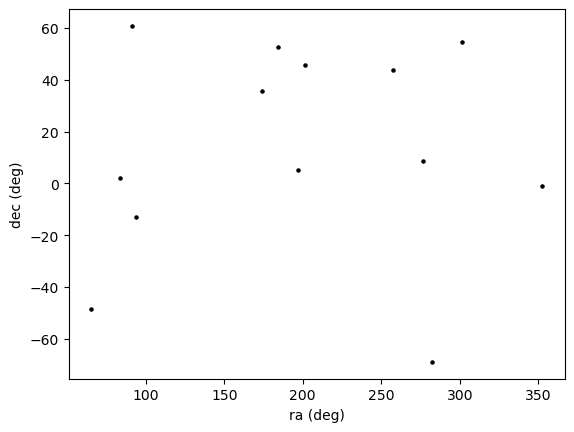

In [15]:
plt.scatter(df['ra'], df['dec'], c='k', s=5)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')

# Using Astroplan

In [16]:
#pip install astroplan

In [17]:
from astroplan import Observer 
from astroplan import FixedTarget
from astroplan import time_grid_from_range
from astropy.time import Time

In [18]:
# I need to set the location to VLT, it is at the Cerro Paranal, Mountain
vlt_location = Observer.at_site('paranal')

In [19]:
# astroplan uses icrs coordinate system 
coords = [SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs') for ra, dec in zip(df['ra'], df['dec'])]

# create a target list 
targets = [FixedTarget(coord=coord) for coord in coords]

- UTC is 5 hours ahead of Tuscaloosa 
- UTC is 4 hours ahead of VLT 

In [20]:
# Need to define the observing time (aka night time) 
start_time = Time.now()
end_time = start_time + 365*u.d  # the next year
time_ran = start_time, end_time
time_range = time_grid_from_range(time_ran, time_resolution=0.5*u.hour)  # 30 minute intervals

In [21]:
from astroplan.constraints import AtNightConstraint, AirmassConstraint
# this will allow me to constrain the observations to the night time & airmass

In [ ]:
# Define constraints
nighttime_constraint = AtNightConstraint.twilight_civil()  # Civil twilight constraint
airmass_constraint = AirmassConstraint(max=3)  # Max airmass constraint (using 3 from the astroplan website)

# Combine constraints
constraints = [nighttime_constraint, airmass_constraint]

In [23]:
from astroplan import ObservingBlock
# this will allow for observing wrt the exposure times neeeded per object 

In [26]:
# observing blocks for each object with the exposure times and number of exposures from above
blocks = []
priority = 1
for idx, row in df.iterrows():
    # RA and Dec for each target
    target_coord = SkyCoord(ra=row['ra']*u.deg, dec=row['dec']*u.deg, frame='icrs')
    target = FixedTarget(coord=target_coord)
    
    
    # Use the calculated exposure time and number of exposures for each filter
    block_uvb = ObservingBlock.from_exposures(
        target, 
        priority, 
        time_per_exposure=row['Time_per_uvb']*u.second, 
        number_exposures=row['Num_exp_uvb'],
        readout_time=10*u.second, 
        constraints=constraints
    )
    blocks.append(block_uvb)

    block_vis = ObservingBlock.from_exposures(
        target, 
        priority, 
        time_per_exposure=row['Time_per_vis']*u.second, 
        number_exposures=row['Num_exp_vis'],
        readout_time=10*u.second, 
        constraints=constraints
    )
    blocks.append(block_vis)

    block_nir = ObservingBlock.from_exposures(
        target, 
        priority, 
        time_per_exposure=row['Time_per_nir']*u.second, 
        number_exposures=row['Num_exp_nir'],
        readout_time=10*u.second, 
        constraints=constraints
    )
    blocks.append(block_nir)